# 1 - Practical

In [2]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

The objective of this part of the coursework is to implement three different ways of valuing put and call options.

Take two numbers, $X_1 = 120$ and $X_2$ calculated as follows. Take your student number, remove zeros and use the remaining digits to make the number closest to $100$. For example, if your student number is $100966240$, after dropping 0s you get $196624$ and can make the number $96$. Do not put your student number on your submission to preserve anonymity.

Consider options with strike prices $X_1$ and $X_2$ of $4$ types (European and American puts and calls) with the time to maturity equal to 6 months (1/2 of a year). 

In total this amounts to 8 different options.
Suppose the following holds:
- current stock price S0 is 100p;
- annual volatility is 20%;
- money can be invested at the annual interest rate (with continuous compounding) of 5% and the investment is virtually riskless; money can be borrowed at the same rate.

You should code up the Black–Scholes formula, binomial trees, and Monte Carlo algorithm, and find the following 20 numbers:
- the prices of the European call and put options computed from the Black–Scholes formula (4 numbers);
- the prices of the European and American call and put options computed using the binomial tree method (with approximately 1 day as the time step) (8 numbers);
- the prices of the European call and put options computed using the Monte Carlo method (with approximately 1 day as the time step) (4 numbers).

In the lectures several variations of each method were considered (e.g., different types of trees or simulations based on different SDEs). It is sufficient to choose one variant. Doing several variants will be considered an extra advantage, but it is not required.
- Hint 1: It is easier to measure time in years (fractions of a year), rather than in days.
- Hint 2: Different methods should return similar values for the same price.
For example, the prices of European options calculated using the Black-Scholes formula, binomial trees, and Monte-Carlo should be the same (or very close, usually within 0.1p).
- Hint 3: If you use Java, you will need to calculate the distribution function N of the Gaussian distribution ϕ(0, 1). You can use the method from the file `CNDF.java` provided on Moodle.

In [3]:
S0: int = 100
X1: int = 120
X2: int = 95  # This value is based on your student number as described in the question
r: float = 0.05
sigma: float = 0.2
T: float = 0.5
N: int = 183  # Approximate number of days in 6 months

## Binomial Trees

- `S0`: the current stock price
- `X`: the strike price
- `r`: the risk-free interest rate
- `sigma`: the volatility
- `T`: the time to maturity
- `N`: the number of time steps
- `option`: option, either `american` or `european`
- `option_type`: the type of option, either 'call' or 'put'

**European**

**Call Option**
$$C_{i,j} = \max(S_{i,j} - X, 0)$$
- $S_{i,j}$ is the price of the underlying asset at time step $i$ and node $j$, $X$ is the strike price
- $C_{i,j}$ is the price of the call option at time step $i$ and node $j$.

**Put Option**
$$P_{i,j} = \max(X - S_{i,j}, 0)$$
- $P_{i,j}$ is the price of the put option at time step $i$ and node $j$.

**American**

**Call Option**
$$ V[i][j] = \max(S[i][j] - X, \max(V[i+1][j+1] * u, V[i+1][j+1] * d)) $$
- $V[i][j]$ is the value of the option at time step j and node i
- $X$ is the strike price of the option
- $S[i][j]$ is the stock price at time step $j$ and node $i$
- $u$ and d are the up and down factors used to calculate the stock price at each node
- $V[i+1][j+1] * u$ and $V[i+1][j+1] * d$ are the estimated option values at the next node in the tree, calculated by multiplying the values of the next time step by the up and down factors

**Put Option**
$$ V[i][j] = \max(X - S[i][j], \max(V[i+1][j+1] * u, V[i+1][j+1] * d)) $$
- $V[i][j]$ is the value of the option at time step j and node i
- $X$ is the strike price of the option
- $S[i][j]$ is the stock price at time step $j$ and node $i$
- $u$ and d are the up and down factors used to calculate the stock price at each node
- $V[i+1][j+1] * u$ and $V[i+1][j+1] * d$ are the estimated option values at the next node in the tree, calculated by multiplying the values of the next time step by the up and down factors

In [4]:
def binomial_tree(S0: int, X: int, r: float, sigma: float, T: float, N: int, option: str, option_type: str) -> float:
    dt: float = T/N # time step
    u: float = np.exp(sigma*np.sqrt(dt)) # up factor by 
    d: float = 1/u # down factor
    p: float = (np.exp(r*dt) - d) / (u - d) # probability of up movement

    stock_price: list[float] = np.zeros((N + 1, N + 1)) # stock price matrix
    option_price: list[float] = np.zeros((N + 1, N + 1)) # option price matrix

    for i in range(N + 1): 
        for j in range(i + 1):
            stock_price[j][i] = S0*(u**(i-j))*(d**j) 

    if option_type == 'call' and option == 'european': 
        option_price[:, N] = np.maximum(np.zeros(N+1), stock_price[:, N] - X)
    elif option_type == 'put' and option == 'european':
        option_price[:, N] = np.maximum(np.zeros(N+1), X - stock_price[:, N])
    elif option_type == 'call' and option == 'american':
        option_price[:, N] = np.maximum(np.zeros(N+1), stock_price[:, N] - X)
    elif option_type == 'put' and option == 'american':
        option_price[:, N] = np.maximum(np.zeros(N+1), X - stock_price[:, N])
    else:
        raise ValueError("Invalid option type")

    for i in range(N - 1, -1, -1):
        for j in range(i + 1): 
            option_price[j][i] = (
                p*option_price[j][i+1] + (1-p) * option_price[j + 1][i + 1]) / np.exp(r * dt) 
            if option_type == 'call' and option == 'american':
                option_price[j][i] = np.maximum(
                    option_price[j][i], stock_price[j][i] - X)
            elif option_type == 'put' and option == 'american':
                option_price[j][i] = np.maximum(
                    option_price[j][i], X - stock_price[j][i])

    return option_price[0][0]

In [5]:
binomial_european_call_X1 = binomial_tree(S0, X1, r, sigma, T, N, 'european', 'call')
binomial_european_put_X1 = binomial_tree(S0, X1, r, sigma, T, N, 'european', 'put')
binomial_american_call_X1 = binomial_tree(S0, X1, r, sigma, T, N, 'american' ,'call')
binomial_american_put_X1 = binomial_tree(S0, X1, r, sigma, T, N, 'american' , 'put')
binomial_european_call_X2 = binomial_tree(S0, X2, r, sigma, T, N, 'european', 'call')
binomial_european_put_X2 = binomial_tree(S0, X2, r, sigma, T, N, 'european', 'put')
binomial_american_call_X2 = binomial_tree(S0, X2, r, sigma, T, N, 'american' , 'call')
binomial_american_put_X2 = binomial_tree(S0, X2, r, sigma, T, N, 'american' , 'put')

print("European call option X1: ", binomial_european_call_X1)
print("European put option X1: ", binomial_european_put_X1)
print("American call option X1: ", binomial_american_call_X1)
print("American put option X1: ", binomial_american_put_X1)
print("European call option X2: ", binomial_european_call_X2)
print("European put option X2: ", binomial_european_put_X2)
print("American call option X2: ", binomial_american_call_X2)
print("American put option X2: ", binomial_american_put_X2)

European call option X1:  1.020785103620697
European put option X1:  18.057974547021804
American call option X1:  1.020785103620697
American put option X1:  20.0
European call option X2:  9.868465238627794
European put option X2:  2.5229068813203352
American call option X2:  9.868465238627794
American put option X2:  2.6379423178025427


## Monte Carlo

- `S0`: the current stock price
- `X`: the strike price
- `r`: the risk-free interest rate
- `sigma`: the volatility
- `T`: the time to maturity
- `N`: the number of time steps
- `M`: number of simulations
- `option`: option, either `american` or `european`
- `option_type`: the type of option, either 'call' or 'put'

**Put Option**
$$ V = \frac{1}{N} * \sum(\max(X - S_T, 0)) $$
- $V$ is the estimated value of the option
- $N$ is the number of simulations run
- $X$ is the strike price of the option
- $S_T$ is the stock price at the final time step (maturity) in a simulation

**Call Option**
$$ V = \frac{1}{N} * \sum(\max(S_T - X, 0)) $$
- $V$ is the estimated value of the option
- $N$ is the number of simulations run
- $X$ is the strike price of the option
- $S_T$ is the stock price at the final time step (maturity) in a simulation

In [6]:
def monte_carlo(S0: int, X: int, r: float, sigma: float, T:float, N: int, M: int, option_type: str) -> float:
    dt: float = T/N # time step
    stock_price: list[float] = np.zeros((M, N+1)) # stock price matrix
    stock_price[:, 0] = S0 # initial sC = S * N(d1) - X * e^{-rT} * N(d2)tock price
    exercise: list[float] = np.zeros((M, N+1)) # exercise matrix

    for i in range(1, N+1): # fill stock price matrix
        z: list[float] = np.random.normal(size = M) # random normal variable
        stock_price[:, i] = stock_price[:, i-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z) # fill stock price matrix

    if option_type == 'call': # if call option
        option_price = np.maximum(np.zeros(M), stock_price[:, N] - X) 
    elif option_type == 'put':
        option_price = np.maximum(np.zeros(M), X - stock_price[:, N])
    else:
        raise ValueError("Invalid option type")

    option_price: float = np.exp(-r*T) * np.mean(option_price)

    return option_price


In [7]:
M: int = 10000  # Number of simulations

monte_european_call_X1 = monte_carlo(S0, X1, r, sigma, T, N, M, 'call')
monte_european_put_X1 = monte_carlo(S0, X1, r, sigma, T, N, M, 'put')
monte_european_call_X2 = monte_carlo(S0, X2, r, sigma, T, N, M, 'call')
monte_european_put_X2 = monte_carlo(S0, X2, r, sigma, T, N, M, 'put')

print("European call option X1: ", monte_european_call_X1)
print("European put option X1: ", monte_european_put_X1)
print("European call option X2: ", monte_european_call_X2)
print("European put option X2: ", monte_european_put_X2)

European call option X1:  1.023095638584512
European put option X1:  17.937788213104753
European call option X2:  9.932986407407249
European put option X2:  2.4728597308354936


## Black-Scholes

- `S0`: the current stock price
- `X`: the strike price
- `r`: the risk-free interest rate
- `sigma`: the volatility
- `T`: the time to maturity
- `N`: the number of time steps
- `option`: option, either `american` or `european`
- `option_type`: the type of option, either 'call' or 'put'

**Put**
$$ C = S * N(d1) - X * e{-rT} * N(d2) $$
- C is the price of the European call option
- S is the current stock price
- X is the strike price of the option
- r is the risk-free interest rate
- T is the time to maturity
- N(d1) and N(d2) are the cumulative distribution functions of the standard normal distribution
- $d1 = \frac{(ln(\frac{S}{X}) + (r + σ^2/2) * T)}{(σ * \sqrt(T))}$
- $d2 = d1 - σ * \sqrt(T)$
- σ is the volatility of the stock

**Call**
$$ P = X * e^{-rT} * N(-d2) - S * N(-d1) $$
- C is the price of the European call option
- S is the current stock price
- X is the strike price of the option
- r is the risk-free interest rate
- T is the time to maturity
- N(d1) and N(d2) are the cumulative distribution functions of the standard normal distribution
- $d1 = \frac{(ln(\frac{S}{X}) + (r + σ^2/2) * T)}{(σ * \sqrt(T))}$
- $d2 = d1 - σ * \sqrt(T)$
- σ is the volatility of the stock

In [8]:
def black_scholes(S0: int, X: int, r: float, delta: float, T: float, option_type: str) -> float:
    d1: float = (np.log(S0 / X) + (r + 0.5 * delta ** 2)*T) / (delta * np.sqrt(T))
    d2: float = d1 - delta * np.sqrt(T)

    if option_type == 'call':
        option_price: float = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price: float = X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type")

    return option_price

In [9]:
black_european_call_X1 = black_scholes(S0, X1, r, sigma, T, 'call')
black_european_put_X1 = black_scholes(S0, X1, r, sigma, T, 'put')
black_european_call_X2 = black_scholes(S0, X2, r, sigma, T, 'call')
black_european_put_X2 = black_scholes(S0, X2, r, sigma, T, 'put')

print("European call option X1: ", black_european_call_X1)
print("European put option X1: ", black_european_put_X1)
print("European call option X2: ", black_european_call_X2)
print("European put option X2: ", black_european_put_X2)

European call option X1:  1.0226152225558796
European put option X1:  18.05980466595578
European call option X2:  9.872742400408974
European put option X2:  2.527184043100572


## Comparison

In [10]:
def compare_methods(monte_carlo_price, binomial_price, black_scholes_price, *limits):
    # plot the results bar chart
    fig, ax = plt.subplots()
    ax.bar(['Monte Carlo', 'Binomial', 'Black-Scholes'], [monte_carlo_price, binomial_price, black_scholes_price])
    ax.set_ylabel('Option price')
    ax.set_title('Comparison of option pricing methods')
    plt.show()

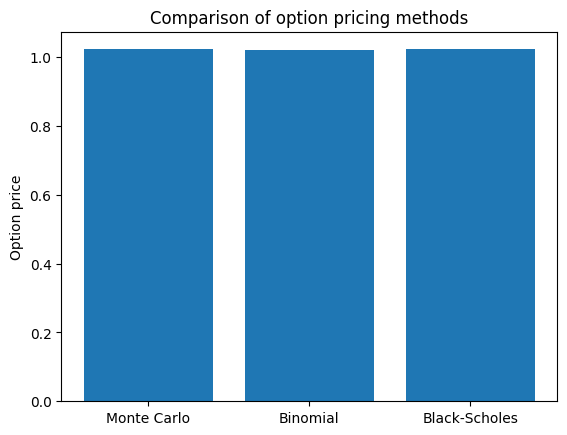

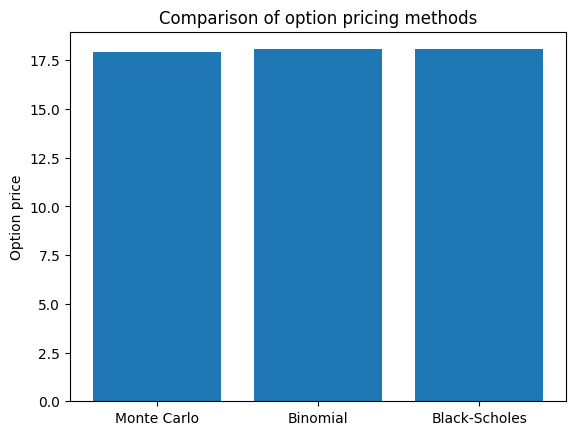

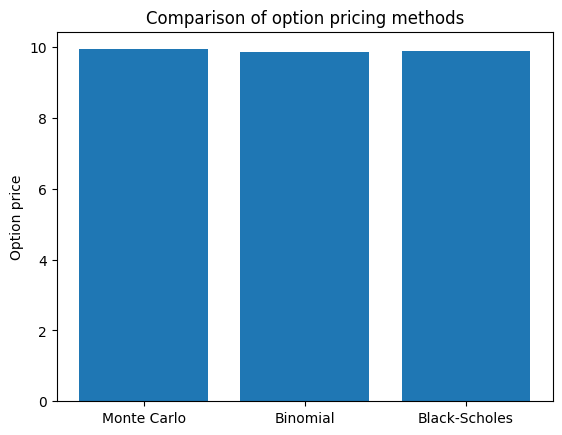

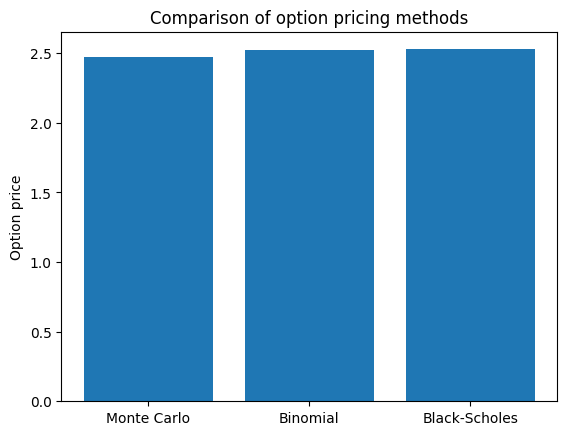

In [11]:
compare_methods(monte_european_call_X1, binomial_european_call_X1, black_european_call_X1, 1.01, 1.03)
compare_methods(monte_european_put_X1, binomial_european_put_X1, black_european_put_X1, 17.8, 18.1)
compare_methods(monte_european_call_X2, binomial_european_call_X2, black_european_call_X2, 9.2, 9.23)
compare_methods(monte_european_put_X2, binomial_european_put_X2, black_european_put_X2, 2.84, 2.86)

All the values are close together hence the calculations are accurate

# 2 - Theory

## Question 1
A company is considering whether to launch a new product. The sum of £170,000 should be spent now on new equipment. It is estimated that there will be a market for the new product for three years and the product will bring £60,000 of profit per year (assume for simplicity that the yearly profit is received at the end of the year as a single payment). Should this project be pursued if the current risk-free interest rate is 5%? Justify your answer.

$$ PV=\frac{CF}{(1+r)^{n}} $$
- $PV$: Present value of the cash flow
- $CF$: future cash flow
- $r$: discount rate
- $n$: years

Year 1 PV: $\frac{60 000}{(1 + 0.05)^1} = 57 142.85714$

Year 2 PV: $\frac{60 000}{(1 + 0.05)^2} = 54 421.76871$

Year 3 PV: $\frac{60 000}{(1 + 0.05)^3} = 51 830.25591$


$\sum{PV} = 57 142.85714 + 54 421.76871 + 51 830.25591 = 163 394.8818$

$ NPV = 163 394.8818 - 170 000 = -6 605.11824$ 

The project should not pursued as it will lead to a lose. 

## Question 2
A bond with the face value of £200 matures in 3 years and makes yearly coupon payments at the coupon rate of 15%. The payments are made at the end of each year.

### Part A
List all payments (with dates and amounts) the bond makes.

Year 1 (31/12/2023): $30$

Year 2 (31/12/2024): $30$

Year 3 (31/12/2025): $ 30 + 200 = 230$

## Part B
Assuming the effective interest rate of 10% pa, calculate the value of the bond.

$$ coupon\_rate * face\_value(\frac{1-(1+r)^{-N}}{r}) + \frac{face\_value}{(1 + r)^N} $$ 

$ 0.15 * 200(\frac{1-(1+0.1)^{-3}}{0.1}) + \frac{200}{(1 + 0.1)^3} = 224.87 $

## Question 3
A European call option with the strike of 40p maturing in half a year on a share is worth 13p. Suppose that the share is currently worth 45p and the risk-free interest rate (with continuous compounding) is 10%.

Calculate the price eliminating arbitrage opportunities of a European put option with the same strike of 40p maturing in half a year on the same share. You do not need to give a complete proof.

$$ P = C + Xe^{-rt} - S $$

$ (13) + (40)e^{-(0.1)(0.5)} - 45 = 6.05 $

## Question 4
Suppose that the price of a share on the spot market is 50p, while the price of a European put option on this share that matures in one month and has the strike price of 55p is 3p. Assume that the risk-free interest rate (with continuous compounding) is 5% pa and the share will not be paying any dividends during the coming two months. This situation implies an arbitrage opportunity. Describe an arbitrage strategy and show that it brings profit.

$ S0 = 50 $

$ X = 55 $

$ r = 0.05 $ 

$ p = 3 $


1. Buy the put option
2. Borrow $ 50 + 3 = 53 $
3. Dept of borrowed money after 1 month will be $ (50 + 3)e^{0.5 / 12} = 53.22 $
4. After the 1 month period, exercise the option. Sell the stock for new strike price of $55$ (original price of $50$) 
5. Pay back the dept of $55.22$
6. Profit of $55 - 53.22 = 1.78$

## Question 5
Suppose that the underlying asset in Question 4 above is a metal rather than a share. Let all the prices be the same as above: the spot price per ounce of the metal be 50p and the price of a European put option on an ounce that matures in one month and has the strike price of 55p be 3p. The metal can be bought or sold with no overhead costs, but its storage incurs the cost of 2p per ounce per month payable up front. Does the arbitrage strategy you described in your answer to Question 4 above still bring profit?

$ S = 50 $

$ X = 55 $

$ r = 0.05 $

$ T = \frac{1}{12} $

$ P = 3 $

$ storage = 2 $


$ (50 + 3 + 2)e^{0.5 / 12} = 57.34 $

$ 55 - 57.34 = 2.34 $

Storage costs will lead to a loss hence there is no arbitrage opportunity. 

## Question 6
Suppose that the option from Questions 4 and 5 is American. Is there an arbitrage opportunity? If so, describe an arbitrage strategy and show that it brings profit in the case when

## Part A
the underlying asset is a share as in Question 4;

In [12]:
S0 = 50
X = 55
r = 0.05
sigma = 0.2 
T = 1/12 
N = 30 # You need to choose a value for N, the number of time steps in the binomial tree
option = 'american'
option_type = 'put'

print(binomial_tree(S0, X, r, sigma, T, N, option, option_type))

5.0


- American holder can exercise option at any time
- Buy cheaper American put and short sell it at the spot price of 50
- If the share price drops, profit is made by re-purchasing the share
- Exercise the option
- In this case 5 is the profit 

## Part B
the underlying asset is a metal as in Question 5.

In [13]:
S0 = 53
X = 55
r = 0.05
sigma = 0.2 
T = 1/12 
N = 30 # You need to choose a value for N, the number of time steps in the binomial tree
option = 'american'
option_type = 'put'

print(binomial_tree(S0, X, r, sigma, T, N, option, option_type))

2.3717437213466037


Same as A but with less profit of 2.37

# Question 7
A generalised Wiener process x(t) starts from the point $x(0) = 10$ and satisfies the stochastic differential equation $dx = 5dt + 3dz$, where $z$ is the Wiener process.

## Part A
What is the distribution of the increment $x(4) − x(0)$? Calculate its parameters.

$$ x(t) = x(0) + at + bz(t) $$

$ x(T_0 + T) -x(T) = x(0) + a(T_0 + T) + bz(T_0 + T) $

$ = x(0) + a(T_0 + T) + bz(T_0 + T) - x(0) + a(T_0) -bz(T_0) $

$ = x(0) + a(T_0 + T) + x(T_0 + T) - x(0) + x(T_0) -bz(T_0) $

$ a(T) + b[ z(T_0) - z(T_0) ] $

$ => Z ~ N(0, [T]) $

$ b => var(cX) = c^2*var(X) -> Z ~ N(0, Tb^2) $

$ x(4) - x(0), T=4 -> dx = 5dt + 3dz $


$ at => ~ ϕ(aT, Tb^2) $

$aT = 5*4 = 20, Tb^2 = 4(3^2) = 36 -> ~ϕ(20, 36)$

## Part B
What is the probability that x(4) < 0? Express the probability in terms of N (x), the cumulative distribution function for ϕ(0, 1), and then use Python or any other tool to calculate it.

$ x(4) ~ ϕ(20 + 10, 36) $

$ P(x(4) < 0) => z = \frac{x(4) - 30}{6} ~ ϕ(0, 1) => x(4) = 6z + 30$

A-Level Maths Technique
$ P(x(4) < 0) = P(6z + 30) < 0 = P(6z < -30) = P(z < -5) $

Using  `Distribution (7)` option Casio FX-991EX Calculator and choosing Normal CD (Cumulative) = $2.867 * 10^{-7}$